In [1]:
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# api setup

api_url = "https://api.football-data.org/v4/"
date_start = "2021-08-01"
date_end = "2023-06-11"
api_key = "fb44fef1e90a45acb1e60b83adfaec1c"
headers = { 'X-Auth-Token': api_key }
team_to_find = "Arsenal"
league = "PL"

In [3]:
build_teams_url = "{}/competitions/{}/teams".format(api_url, league)
teams_request = requests.get(build_teams_url, headers=headers)

In [4]:
teams = teams_request.json()["teams"]

# get the team to search for from the list
team = [team for team in teams if team['shortName'] == team_to_find][0]

team_name = team['name']
team_id = team['id']
team_id 

57

In [5]:
# Next, let's make a request for the matches for that team. We'll limit the search within a period of time
build_historical_matches_url = "{}/teams/{}/matches?dateFrom={}&dateTo={}".format(api_url, team_id, date_start, date_end)
matches_request = requests.get(build_historical_matches_url, headers=headers)

In [10]:
# Historical_data
historical_matches = matches_request.json()

historical_matches = [match for match in historical_matches["matches"]]

h_away_goals = [match['score']['fullTime']['away'] for match in historical_matches if match['awayTeam']['id'] == team_id ]
h_home_goals = [match['score']['fullTime']['home'] for match in historical_matches if match['homeTeam']['id'] == team_id ]

# Check for average home goals
h_avg_home_goals = np.mean(h_home_goals)
h_avg_away_goals = np.mean(h_away_goals)

h_avg_goals_per_game = (h_avg_home_goals + h_avg_away_goals) / 2
print("Historical Average Goals Per Game: " + str(round(h_avg_goals_per_game, 1)))

Historical Average Goals Per Game: 2.0


In [16]:
# get recent data

recent_home_goals = h_home_goals[-30:]
recent_away_goals = h_away_goals[-30:]

goals_combined = recent_home_goals + recent_away_goals

avg_goals_combined = sum(goals_combined)/len(goals_combined)
# from the more recent games, let's select random scores for our hypothesis test
print("Recent Goals Average: " + str(round(avg_goals_combined, 1)))

Recent Goals Average: 2.1


In [19]:
# Get data from last season (last 38 games)
ls_home_goals = h_home_goals[-19:]
ls_away_goals = h_away_goals[-19:]

ls_goals_combined = ls_home_goals + ls_away_goals

ls_avg_goals_combined = sum(ls_goals_combined)/len(ls_goals_combined)
print("Average Goals Last 38 games: " + str(round(sum(ls_goals_combined)/len(ls_goals_combined),1)))

Average Goals Last 38 games: 2.3


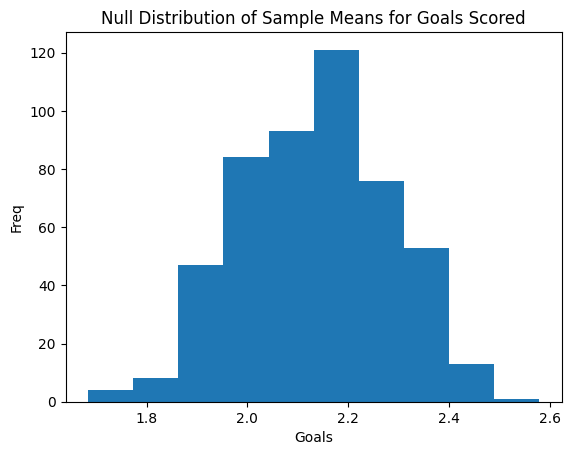

<Figure size 640x480 with 0 Axes>

In [13]:
# Next, we define our null and alternative hypothesis
# Null Hypothesis: The Average goals scored by the team is 2.1 / game
# Alternative: The Average goals scored by the team is greater than 1.96
# Significance Threshold: 0.05
# Confidence Interval: 95%

# Let's simulate repeated random samples from our recent data
avg_goals_list = []
for i in range(500):
    goals = np.random.choice(goals_combined, size=38, replace=False)
    goals_avg = np.mean(goals)
    avg_goals_list.append(goals_avg)

plt.hist(avg_goals_list)
plt.title("Null Distribution of Sample Means for Goals Scored")
plt.xlabel("Goals")
plt.ylabel("Freq")
plt.show()
plt.clf()

In [14]:
# Now we can check for the confidence interval
# check if the observed average of 2.3 falls within our confidence interval so we can confirm if our null hypothesis is true

interval = np.percentile(avg_goals_list, [2.5, 97.5])
interval

array([1.86842105, 2.42105263])

In [23]:
# Hence, we're 95% certain that the team scores between 1.8 and 2.4 goals per game
# Let's calculate the P-Value
vals = [val for val in avg_goals_list if val > 2.3]
p_val = np.sum(vals)/len(avg_goals_list)
p_val

0.31768421052631585

In [22]:
# From the above, we can see that the p-value is above our significant threshold of 0.05 hence we accept the null hypothesis
# and conclude that their is a 29% chance of the average goals scored per game being 2.1 or above.

stat, p_val = st.ttest_1samp(ls_goals_combined, 2.3)
p_val/2

0.472414850839304